# Dev notebook for updates

`Lanczos optimization`

In [4]:
import numpy as np
from dmrg_src.MPS import MPS
from dmrg_src.MPO import MPO_TFI
from dmrg_src.CONT import CONT
from dmrg_src.dmrg import dmrg
from dmrg_src.obs import observables

import matplotlib.pyplot as plt
import os
import shutil
from tqdm import tqdm

### Class 

In [ ]:
import numpy as np
from scipy.linalg import eigh_tridiagonal
from scipy.sparse.linalg import ArpackNoConvergence


class EffH():

    def __init__(self,L,R,H,site,k=300):
        self.L = L 
        self.R = R 
        self.H = H 
        self.k = k
        self.d = H.d
        self.site = site
        c1,_,_ = L.shape
        c2,_,_ = R.shape
        self.c1 = c1
        self.c2 = c2
        self.len_vec = c1*c2*self.d**2
        self.k = min(c1*c2*self.d**2,k)

    def __str__(self):
        return 'Effective Hamiltonian on the Cayley tree'
    
    def __repr__(self):
        return 'Effective Hamiltonian on the Cayley tree'

    def matvec(self,psi):
        h = self.H
        psi = np.reshape(psi,(self.c1,self.d,self.d,self.c2))
        
        x = np.tensordot(self.L,h.mpo(p=self.site),(1,2))
        x = np.tensordot(x,psi,[(0,2),(0,1)])
        x = np.tensordot(x,h.mpo(p=self.site+1),[(2,3),(2,0)])
        x = np.tensordot(x,self.R,[(4,2),(1,0)])
        
        return np.reshape(x,(self.c1*self.d*self.d*self.c2))
    
    def lanc_iter(self,psi0,exc='off'):
        psi0 = psi0/np.linalg.norm(psi0)
        vecs = [psi0] 

        T = np.zeros((self.k,self.k))
        
        psi = self.matvec(psi0)
        alpha = T[0, 0] = np.inner(psi0.conj(),psi).real
        psi = psi - alpha* vecs[-1]
        
        for i in range(1,self.k):
            beta = np.linalg.norm(psi)
            if beta  < 1e-8:
                T = T[:i, :i]
                break
            if exc == 'off':
                psi /= beta
            if exc == 'on':
                psi_o = psi
                for j in range(i):
                    psi_o -= (psi.conj()@vecs[j])*vecs[j]
                psi = psi_o/np.linalg.norm(psi_o)
            vecs.append(psi)
            psi = self.matvec(psi) - beta*vecs[-2]
            alpha = psi.conj()@vecs[-1]
            psi = psi - alpha * vecs[-1] 
            T[i, i] = alpha.real
            T[i-1, i] = T[i, i-1] = beta    
        
        return T, (np.array(vecs).T).conj()

    def lanc_iter_old(self,psi0,exc='off'):
        psi0 = psi0/np.linalg.norm(psi0)
        vecs = [psi0] 

        T = np.zeros((self.k,self.k))
        
        psi = self.matvec(psi0)
        alpha = T[0, 0] = np.inner(psi0.conj(),psi).real
        psi = psi - alpha* vecs[-1]
        
        for i in range(1,self.k):
            beta = np.linalg.norm(psi)
            if beta  < 1e-8:
                T = T[:i, :i]
                break
            if exc == 'off':
                psi /= beta
            if exc == 'on':
                psi_o = psi
                for j in range(i):
                    psi_o -= (psi.conj()@vecs[j])*vecs[j]
                psi = psi_o/np.linalg.norm(psi_o)
            vecs.append(psi)
            psi = self.matvec(psi) 
            alpha = np.inner(vecs[-1].conj(), psi).real
            psi = psi - alpha * vecs[-1] - beta * vecs[-2]
            T[i, i] = alpha
            T[i-1, i] = T[i, i-1] = beta    
        return T, np.array(vecs).T

    def lanc_iter_new(self,psi0,exc='off'):
        psi0 = psi0/np.linalg.norm(psi0)
        vecs = [psi0] 

        T = np.zeros((self.k,self.k))
        
        psi = self.matvec(psi0)
        alpha = T[0, 0] = np.inner(psi0.conj(),psi).real
        psi = psi - alpha* vecs[-1]
        
        for i in range(1,self.k):
            beta = np.linalg.norm(psi)
            if np.abs(beta)  < 1e-8:
                T = T[:i, :i]
                break
            if exc == 'off':
                psi /= beta
            if exc == 'on':
                psi_o = psi
                for j in range(i):
                    psi_o -= (psi.conj()@vecs[j])*vecs[j]
                psi = psi_o/np.linalg.norm(psi_o)
            vecs.append(psi)
            psi = self.matvec(psi) 
            alpha = np.inner(vecs[-1].conj(), psi).real
            psi = psi - alpha * vecs[-1] - beta * vecs[-2]
            T[i, i] = alpha
            T[i-1, i] = T[i, i-1] = beta    
        return T, np.array(vecs).T

    def lanczos_grd(self,psi0=None,exc='off'):
        if psi0 is None:
            psi0 = np.random.rand(self.c1*self.c2*self.d**2)
        T, vecs = self.lanc_iter_old(psi0,exc=exc)

        try:
            E,v = eigh_tridiagonal(np.diag(T),np.diag(T,k=1),select='i',select_range=(0,2))
            # E,v = np.linalg.eigh(T)
            result = vecs @ v[:, np.argmin(E)]
            if exc == 'off':
                E = min(E)
                
        except ArpackNoConvergence as err:
            print('Lanczos did not converge !!!')
            E = psi0.conj()@self.matvec(psi0)
            result = psi0
        
        except LinAlgError as err:
            print('Lanczos did not converge !!!')
            E = psi0.conj()@self.matvec(psi0)
            result = psi0
        
        except ValueError:
            print('Lanczos did not converge !!!')
            E = psi0.conj()@self.matvec(psi0)
            result = psi0


        return E, result

In [ ]:
import os 
import psutil
import numpy as np

class MPS():
    
    def __init__(self,L,d=2,path='MPS'):
        self.L = L 
        self.d = d
        self.S = {}
        self.path = path
        self.ram = MPS.ram(self)
        self.disk = MPS.disk(self)

    def write(self,i,ten):
        # try:
        self.ram.write(i,ten)
        # except ValueError:
        #     self.ram.mps.pop(i)
        #     self.disk.write(i,ten)
        # except KeyError:
        #     self.disk.write(i,ten)

    def read(self,i):
        # try: 
        return self.ram.read(i)
        # except KeyError:
        #     return self.disk.read(i)

    def writeS(self,i,ten):
        self.S.update({i:ten})
    
    def readS(self,i):
        return self.S[i]

    def write_left(self,i,mat):
        self.write(i,self.left_ten(mat))

    def write_right(self,i,mat):
        self.write(i,self.right_ten(mat))

    def delete(self,i):
        if os.path.isfile(self.path+f'/S/{i}-{i+1}.dat'):
            os.remove(self.path+f'/S/{i}-{i+1}.dat')
            os.remove(self.path+f'/S/{i}-{i+1}.txt')
            
    def left_ten(self,mat):
        
        d = self.d
        a,b = mat.shape
        ten = np.zeros((d,int(a/d),b),dtype='complex')

        for i0 in range(d):
            for i1 in range(int(a/d)):
                ten[i0,i1,:] = mat[i1*d+i0,:]

        return ten

    
    def right_ten(self,mat):

        d = self.d
        a,b = mat.shape
        ten = np.zeros((d,a,int(b/d)),dtype='complex')

        for i0 in range(d):
            for i2 in range(int(b/d)):
                ten[i0,:,i2] = mat[:,i0*int(b/d)+i2]

        return ten

    def first_sweep(self):
        half_right = [i for i in range(self.L//2 +self.L%2,self.L-2)]
        left = [self.L-4-i for i in range(self.L-4)]
        return zip(half_right+left,['r']*(self.L//2-2)+['l']*(self.L-4))

    def sweep(self):
        right = [i for i in range(2,self.L-2)]
        left = [self.L-4-i for i in range(self.L-4)]
        return zip(right+left,['r']*(self.L-4)+['l']*(self.L-4))

    def right_sweep(self):
        right = [i for i in range(2,self.L-2)]
        return zip(right,['r']*(self.L-4))

    def left_sweep(self):
        left = [self.L-4-i for i in range(self.L-4)]
        return zip(left,['l']*(self.L-4))

    def random(self):
        ten = np.random.random((self.d,self.d,self.d))
        for i in range(1,self.L-1):
            self.write(i,ten)
        self.writeS(self.L//2-1+self.L%2,np.identity(self.d))

    class ram:

        def __init__(self,parent):
            self.parent = parent
            self.max = self.max_size()

            # initialise the ram MPS
            self.mps = self.empty_MPS()
            

        @property
        def L(self):
            return self.parent.L

        @property
        def d(self):
            return self.parent.d

        
        def max_size(self):
            mem = psutil.virtual_memory()
            
            return int(np.sqrt(mem.available/(3*16*self.L*self.d)))

        def write(self,i,ten):
            self.mps.update({i:ten})
        
        def read(self,i):
            return self.mps[i]
        
        def empty_MPS(self):
            mps = {}
            mps.update({0:np.eye(self.d)})
            mps.update({self.L-1:np.eye(self.d)})
            return mps

    class disk:

        def __init__(self,parent):
            self.parent = parent

        @property
        def L(self):
            return self.parent.L
        
        @property
        def d(self):
            return self.parent.d

        @property
        def path(self):
            return self.parent.path

        def empty_MPS(self):
            if os.path.isdir(self.path):
                shutil.rmtree(self.path)
            os.mkdir(self.path)
            for i in range(L):
                open(self.path+f'/ten_{i}.dat','w')
            self.write(0,np.eye(self.d))
            self.write(L-1,np.eye(self.d))
            if L%2 == 1:
                self.write(1,np.reshape(np.eye(self.d**2)[:,:d],(d,d,d)))

        def write(self,i,ten):
            f1 = np.memmap(self.path+f'/ten_{i}.dat',dtype='complex',mode='w+',shape=ten.shape)
            f1[:] = ten
            with open(self.path+f'/ten_{i}.txt','w') as f2: 
                f2.writelines(repr(ten.shape))
            del f1,f2

        
        def shape(self,i):
            s = open(self.path+f'/ten_{i}.txt','r')
            return eval(s.read())


        def read(self,i):
            return np.memmap(self.path+f'/ten_{i}.dat',dtype='complex',mode='r',shape=self.shape(i))

    

In [ ]:
import os 
import psutil
import numpy as np
import sys
import shutil
from collections import OrderedDict

class MPS():
    """MPS with RAM budget and automatic eviction to disk (LRU).

    Parameters
    ----------
    L : int
        Number of sites
    d : int
        Physical dimension
    path : str
        Directory used for disk storage
    ram_budget_mb : float or None
        Maximum RAM (in MB) to keep tensors in memory. If None, uses half
        of currently available memory as a default.
    """
    def __init__(self, L, d=2, path='MPS', ram_budget_mb=None):
        self.L = L
        self.d = d
        self.S = {}
        self.path = path
        # bytes budget
        self.ram_budget_bytes = None if ram_budget_mb is None else int(ram_budget_mb * 1024**2)
        # nested helpers
        self.ram = MPS.ram(self, budget_bytes=self.ram_budget_bytes)
        self.disk = MPS.disk(self)

    def write(self, i, ten):
        # delegate to ram which will evict to disk as needed
        self.ram.write(i, ten)

    def read(self, i):
        # read from ram (ram will pull from disk if necessary)
        return self.ram.read(i)

    def writeS(self, i, ten):
        self.S[i] = ten
    
    def readS(self, i):
        return self.S[i]

    def write_left(self, i, mat):
        self.write(i, self.left_ten(mat))

    def write_right(self, i, mat):
        self.write(i, self.right_ten(mat))

    def delete(self, i):
        # delete possible disk file and memory entry
        if i in self.ram.mps:
            obj, _ = self.ram.mps.pop(i)
            self.ram._decrease_bytes(obj)
            try:
                del obj
            except Exception:
                pass
            if i in self.ram.lru:
                del self.ram.lru[i]
        disk_path = self.path + f'/ten_{i}.dat'
        if os.path.isfile(disk_path):
            os.remove(disk_path)
            txt = self.path + f'/ten_{i}.txt'
            if os.path.isfile(txt):
                os.remove(txt)
            
    def left_ten(self, mat):
        d = self.d
        a, b = mat.shape
        # vectorized reshape: mat rows are grouped by d
        ten = mat.reshape(int(a/d), d, b).transpose(1,0,2)
        return ten.astype(np.complex128)

    def right_ten(self, mat):
        d = self.d
        a, b = mat.shape
        ten = mat.reshape(a, int(b/d), d).transpose(2,0,1)
        return ten.astype(np.complex128)

    def first_sweep(self):
        half_right = [i for i in range(self.L//2 + self.L%2, self.L-2)]
        left = [self.L-4-i for i in range(self.L-4)]
        return zip(half_right+left, ['r']*(self.L//2-2)+['l']*(self.L-4))

    def sweep(self):
        right = [i for i in range(2, self.L-2)]
        left = [self.L-4-i for i in range(self.L-4)]
        return zip(right+left, ['r']*(self.L-4)+['l']*(self.L-4))

    def right_sweep(self):
        right = [i for i in range(2, self.L-2)]
        return zip(right, ['r']*(self.L-4))

    def left_sweep(self):
        left = [self.L-4-i for i in range(self.L-4)]
        return zip(left, ['l']*(self.L-4))

    def random(self):
        ten = np.random.random((self.d, self.d, self.d)).astype(np.complex128)
        for i in range(1, self.L-1):
            self.write(i, ten)
        self.writeS(self.L//2-1+self.L%2, np.identity(self.d))

    class ram:
        """In-memory store with budget and LRU eviction."""
        def __init__(self, parent, budget_bytes=None):
            self.parent = parent
            # determine budget: passed value or half of available memory
            if budget_bytes is None:
                avail = psutil.virtual_memory().available
                self.budget_bytes = int(avail // 2)
            else:
                self.budget_bytes = int(budget_bytes)

            # store mapping: idx -> (ndarray, shape)
            self.mps = {}
            # LRU order: keys -> None (OrderedDict used for O(1) pop/insert)
            self.lru = OrderedDict()
            # total bytes of arrays stored
            self.total_bytes = 0

        def _entry_size(self, arr):
            try:
                return int(arr.nbytes)
            except Exception:
                return int(sys.getsizeof(arr))

        def _increase_bytes(self, arr):
            self.total_bytes += self._entry_size(arr)

        def _decrease_bytes(self, arr):
            self.total_bytes -= self._entry_size(arr)
            if self.total_bytes < 0:
                self.total_bytes = 0

        def ensure_budget(self):
            # Evict least-recently-used until under budget
            while self.budget_bytes is not None and self.total_bytes > self.budget_bytes and len(self.lru) > 0:
                oldest_key, _ = self.lru.popitem(last=False)
                arr, shape = self.mps.pop(oldest_key)
                self._decrease_bytes(arr)
                # write to disk
                try:
                    self.parent.disk.write(oldest_key, arr)
                except Exception:
                    # fallback: ignore disk write failures but continue
                    pass

        def write(self, i, ten):
            # store a memory copy of the tensor
            arr = np.array(ten, copy=True)
            # if already present, remove old size
            if i in self.mps:
                old_arr, _ = self.mps[i]
                self._decrease_bytes(old_arr)
            # store
            self.mps[i] = (arr, arr.shape)
            # update LRU
            self.lru[i] = None
            self.lru.move_to_end(i)
            # update size and evict if needed
            self._increase_bytes(arr)
            self.ensure_budget()

        def read(self, i):
            # if in RAM, return requested slice/view
            if i in self.mps:
                arr, shape = self.mps[i]
                # update LRU
                if i in self.lru:
                    self.lru.move_to_end(i)
                idx = shape
                if 1 <= i < self.parent.L-1:
                    return arr[:, :idx[-2], :idx[-1]]
                else:
                    return arr.copy()
            # otherwise load from disk and bring into RAM
            else:
                try:
                    arr = self.parent.disk.read(i)
                except Exception:
                    raise KeyError(f"Tensor {i} not found on disk or RAM")
                # arr may be a memmap -> copy into memory
                arr_copy = np.array(arr, copy=True)
                self.write(i, arr_copy)
                return arr_copy

    class disk:
        def __init__(self, parent):
            self.parent = parent
            # ensure path exists
            if not os.path.isdir(self.parent.path):
                os.makedirs(self.parent.path, exist_ok=True)

        @property
        def path(self):
            return self.parent.path

        def write(self, i, ten):
            # create memmap file and store shape metadata
            shape = ten.shape
            fpath = self.path + f'/ten_{i}.dat'
            txtpath = self.path + f'/ten_{i}.txt'
            # ensure directory exists
            os.makedirs(self.path, exist_ok=True)
            f1 = np.memmap(fpath, dtype='complex128', mode='w+', shape=shape)
            f1[:] = ten
            with open(txtpath, 'w') as f2:
                f2.writelines(repr(shape))
            del f1

        def shape(self, i):
            txtpath = self.path + f'/ten_{i}.txt'
            with open(txtpath, 'r') as s:
                return eval(s.read())

        def read(self, i):
            shape = self.shape(i)
            fpath = self.path + f'/ten_{i}.dat'
            return np.memmap(fpath, dtype='complex128', mode='r', shape=shape)

In [ ]:
class CONT:

    dir = {'l':'/LEFT','r':'/RIGHT'}
    count = {'l':0,'r':1}

    def __init__(self,mps,H,path='CONT'):
        self.mps = mps
        self.d = mps.d
        self.h = H 
        self.L = mps.L
        self.path = path

        self.ram = CONT.ram(self)
        self.disk = CONT.disk(self)

        pop_dict = {'l':self.ram.LEFT,'r':self.ram.RIGHT}

    def write(self,i,ten,dir):
        try:
            self.ram.write(i,ten,dir)
        except ValueError:
            pop_dict[dir].pop(i)
            self.disk.write(i,ten,dir)
        except KeyError:
            self.disk.write(i,ten,dir)


    def read(self,i,dir):
        try:
            return self.ram.read(i,dir)
        except KeyError:
            return self.disk.read(i,dir)

    def left(self,site):
        """ 
        Contract all the tensors left of site including it 
        """
        h = self.h
        res = np.tensordot(np.tensordot(self.mps.read(0),h.Wl(),(0,0)),np.conj(self.mps.read(0)),(1,0))
        for i in range(1,site+1):
            res = np.tensordot(res,self.mps.read(i),(0,1))
            res = np.tensordot(res,h.mpo(p=i),([0,2],[2,0]))
            res = np.tensordot(res,np.conj(self.mps.read(i)),([0,2],[1,0]))

        return res

    def right(self,site):
        """
        Contract all the tensors right of site including it
        """
        h = self.h
        res = np.tensordot(np.tensordot(self.mps.read(self.L-1),h.Wr(),(0,0)),np.conj(self.mps.read(self.L-1)),(1,0))
        for i in range(1,self.L-site):
            res = np.tensordot(res,self.mps.read(self.L-1-i),(0,2))
            res = np.tensordot(res,h.mpo(p=self.L-1-i),([0,2],[3,0]))
            res = np.tensordot(res,np.conj(self.mps.read(self.L-1-i)),([0,2],[2,0]))
        
        return res

    
    def add(self,site,dir):
        ten = self.read(site-(-1)**self.count[dir],dir)

        # print(ten)
        # print(self.mps.read(site).shape)

        ten = np.tensordot(ten,self.mps.read(site),(0,1+self.count[dir]))
        ten = np.tensordot(ten,self.h.mpo(p=site),([0,2],[2+self.count[dir],0]))
        ten = np.tensordot(ten,np.conj(self.mps.read(site)),([0,2],[1+self.count[dir],0]))

        self.write(site,ten,dir)
        return ten
    
    def env_prep(self,site):
        
        return self.read(site - 1,'l'),self.read(site + 2,'r')
        
    class ram:

        def __init__(self,parent):
            self.parent = parent

            self.LEFT = self.empty_LEFT()
            self.RIGHT = self.empty_RIGHT()

            self.CONTS = {'l': self.LEFT,'r':self.RIGHT}


        @property
        def L(self):
            return self.parent.L

        @property
        def d(self):
            return self.parent.d
        
        @property
        def h(self):
            return self.parent.h

        @property
        def mps(self):
            return self.parent.mps
        
        # @property
        # def path(self):
        #     return self.parent.path


        def write(self,i,ten,dir):
            self.CONTS[dir].update({i:ten})

        def read(self,i,dir):
            return self.CONTS[dir][i]
    

        def empty_LEFT(self):
            left = {}
            left.update({0:self.parent.left(0)})
            return left

        def empty_RIGHT(self):
            right = {}
            ten_r = np.tensordot(np.tensordot(self.mps.read(self.L-1),self.h.Wr(),(0,0)),np.conj(self.mps.read(self.L-1)),(1,0))
            right.update({self.L-1:ten_r})
            return right

    class disk:

        def __init__(self,parent):
            self.parent = parent
            self.path = self.parent.path
            self.empty_CONT()

        @property
        def L(self):
            return self.parent.L

        @property
        def d(self):
            return self.parent.d
        
        @property
        def h(self):
            return self.parent.h

        @property
        def mps(self):
            return self.parent.mps

        def empty_CONT(self):
            if os.path.isdir(self.path):
                shutil.rmtree(self.path)
            os.mkdir(self.path)
            os.mkdir(self.path+'/LEFT')
            os.mkdir(self.path+'/RIGHT')
            for i in range(self.L - 3):
                open(self.path+f'/LEFT/cont_{i}.dat','w')
                open(self.path+f'/RIGHT/cont_{self.L-i-1}.dat','w')

        def write(self,site,ten,dir):
            if dir != 'l' and dir != 'r':
                raise ValueError('the direction needs to be either l or r !!!')

            tenmap = np.memmap(self.path+self.dir[dir]+f'/cont_{site}.dat',dtype='complex',mode='w+',shape=ten.shape)
            tenmap[:] = ten
            with open(self.path+self.dir[dir]+f'/cont_{site}.txt','w') as f:
                f.writelines(repr(ten.shape))
            del tenmap,f

        def shape(self,site,dir):
            s = open(self.path+self.dir[dir]+f'/cont_{site}.txt','r')
            return eval(s.read())

        def read(self,site,dir):
            return np.memmap(self.path+self.dir[dir]+f'/cont_{site}.dat',dtype='complex',mode='r',shape=self.shape(site,dir))

### MPO

In [ ]:
class MPO_Ioannis():
    Id = np.identity(2)
    X = np.array([[0, 1], [1, 0]])
    Y = np.array([[0, 0-1j], [0+1j, 0]])
    Z = np.array([[1, 0], [0, -1]])
    def __init__(self, h, k, J, pol=None, d=2):
        self.h = h
        self.k = k
        self.J = J

        self.pol = pol
        self.d = d

    def Wl(self):
        Wleft = np.zeros((2, 2, 9),dtype='complex')
        Wleft[:, :, 0] = self.Id
        Wleft[:, :, 1] = self.X
        Wleft[:, :, 2] = self.Y
        Wleft[:, :, 3] = self.Z
        Wleft[:, :, 8] = self.h * self.Z

        if self.pol == 'tot':
            Wleft[:,:,8] += 25*self.X

        return Wleft

    def Wr(self):
        Wright = np.zeros((2, 2, 9),dtype='complex')
        Wright[:, :, 0] = self.h * self.Z
        Wright[:, :, 1] = self.J * self.X
        Wright[:, :, 4] = self.k * self.Y
        Wright[:, :, 5] = -self.k * self.X
        Wright[:, :, 6] = self.k * self.Z
        Wright[:, :, 7] = -self.k * self.X
        Wright[:, :, 8] = self.Id

        if self.pol == 'tot':
            Wright[:,:,0] -= 25*self.X

        return Wright

    def mpo(self, p=None):
        MPO = np.zeros((2, 2, 9, 9),dtype='complex')

        # All interactions
        MPO[:,:,0, 0] = self.Id
        MPO[:,:,0, 1] = self.X
        MPO[:,:,0, 2] = self.Y
        MPO[:,:,0, 3] = self.Z
        MPO[:,:,0, 8] = self.h * self.Z

        MPO[:,:,1, 4] = self.Id
        MPO[:,:,1, 6] = self.Y
        MPO[:,:,2, 5] = self.Id
        MPO[:,:,3, 7] = self.Y

        MPO[:,:,1, 8] = self.J * self.X
        MPO[:,:,4, 8] = self.k * self.Y
        MPO[:,:,5, 8] = -self.k * self.X
        MPO[:,:,6, 8] = self.k * self.Z
        MPO[:,:,7, 8] = -self.k * self.X
        MPO[:,:,8, 8] = self.Id

        return MPO

In [ ]:
class MPO_AL_test():

    Id2 = np.identity(2)
    Id4 = np.identity(4)
    Sp = np.array([[0,1],[0,0]])
    Sm = np.array([[0,0],[1,0]])
    Z = np.array([[1,0],[0,-1]])
    d = 4

    sub_BC = [0,2,3]
    sub_A = [1,4]

    def __init__(self,t_1,t_2,U,e_A,mu):
        self.t_1 = t_1
        self.t_2 = t_2
        self.U = U
        self.e_A = e_A
        self.mu = mu
        self.OP = [np.kron(self.Sm,self.Id2),np.kron(self.Sp,self.Id2),np.kron(self.Z,self.Sm),np.kron(self.Z,self.Sp)]
        self.coeff = [[self.t_1,self.t_2,self.t_2,0,0],
                    [self.t_1,self.t_2,self.t_1,0,self.t_2],
                    [0,self.t_2,self.t_1,0,self.t_2],
                    [0,self.t_1,self.t_2,0,self.t_2],
                    [0,self.t_1,0,0,self.t_2]]

    
    def mpo(self, p):
        # FIX: Use fixed bond dimensions (22x22), not variable dimensions
        MPO = np.zeros((4, 4, 22, 22), dtype='complex128')

        MPO[:,:,0,0] = self.Id4
        MPO[:,:,0,1] = np.kron(self.Sp,self.Z)
        MPO[:,:,0,6] = np.kron(self.Sm,self.Z)
        MPO[:,:,0,11] = np.kron(self.Id2,self.Sp)
        MPO[:,:,0,16] = np.kron(self.Id2,self.Sm)
        MPO[:,:,0,21] = -self.mu*(np.kron(self.Z,self.Id2) + np.kron(self.Id2,self.Z))

        # sublattice conditions
        if (p-1)%5 in self.sub_BC:
            MPO[:,:,0,21] += self.U*np.kron(self.Z,self.Z)
        
        if (p-1)%5 in self.sub_A:
            MPO[:,:,0,21] += self.e_A*(np.kron(self.Z,self.Id2) + np.kron(self.Id2,self.Z))

        for j in range(4):
            for i in range(4):
                MPO[:,:,1 +j*5 +i,2+j*5+i] = np.kron(self.Z,self.Z)

        
        for j in range(1,6):
            for i in range(4):
                MPO[:,:,j+5*i,21] = self.coeff[(p-1)%5][j-1]*self.OP[i]

        MPO[:,:,21,21] = self.Id4

        return MPO

    def Wl(self):

        Wleft = np.zeros((4,4,22), dtype='complex128')

        Wleft[:,:,0] = self.Id4
        Wleft[:,:,1] = np.kron(self.Sp,self.Z)
        Wleft[:,:,6] = np.kron(self.Sm,self.Z)
        Wleft[:,:,11] = np.kron(self.Id2,self.Sp)
        Wleft[:,:,16] = np.kron(self.Id2,self.Sm)
        Wleft[:,:,21] = (-self.mu + self.e_A )*(np.kron(self.Z,self.Id2) + np.kron(self.Id2,self.Z)) 

        return Wleft

    def Wr(self):

        Wright = np.zeros((4,4,22), dtype='complex128')

        for j in range(1,6):
            for i in range(4):
                Wright[:,:,j+5*i] = self.coeff[1][j-1]*self.OP[i]

        Wright[:,:,21] = self.Id4

        return Wright

In [ ]:
class MPO_XY():

    X = np.array([[0,1],[1,0]])
    Y = np.array([[0,-1j],[1j,0]])
    Id = np.identity(2)
    d = 2

    def __init__(self,J=1):
        self.J = J 

    def Wl(self,p=None):
        Wl = np.zeros((2,2,4),dtype='complex')

        Wl[:,:,0] = self.Id
        Wl[:,:,1] = self.X 
        Wl[:,:,2] = self.Y 

        return Wl 

    def mpo(self,p=None):

        MPO = np.zeros((2,2,4,4),dtype='complex')

        MPO[:,:,0,0] = self.Id 
        MPO[:,:,0,1] = self.X 
        MPO[:,:,0,2] = self.Y 
        
        MPO[:,:,1,3] = self.J*self.Y
        MPO[:,:,2,3] = self.J*self.X 
        
        MPO[:,:,3,3] = self.Id 

        return MPO 

    def Wr(self,p=None):

        Wr = np.zeros((2,2,4),dtype='complex')

        Wr[:,:,1] = self.J*self.Y
        Wr[:,:,2] = self.J*self.X 
        Wr[:,:,3] = self.Id 

        return Wr

In [ ]:
class MPO_XY_big():

    X = np.kron(np.array([[0,1],[1,0]]),np.array([[1,0],[0,1]]))
    Y = np.kron(np.array([[0,-1j],[1j,0]]),np.array([[1,0],[0,1]]))
    Z = np.kron(np.identity(2),np.array([[1,0],[0,-1]]))
    Id = np.identity(4)
    d = 4

    def __init__(self,J=1):
        self.J = J 

    def Wl(self,p=None):
        Wl = np.zeros((4,4,4),dtype='complex')

        Wl[:,:,0] = self.Id
        Wl[:,:,1] = self.X 
        Wl[:,:,2] = self.Y 
        Wl[:,:,3] = self.Z

        return Wl 

    def mpo(self,p=None):

        MPO = np.zeros((4,4,4,4),dtype='complex')

        MPO[:,:,0,0] = self.Id 
        MPO[:,:,0,1] = self.X 
        MPO[:,:,0,2] = self.Y 
        MPO[:,:,0,3] = self.Z
        
        MPO[:,:,1,3] = self.J*self.Y
        MPO[:,:,2,3] = self.J*self.X 
        
        MPO[:,:,3,3] = self.Id 

        return MPO 

    def Wr(self,p=None):

        Wr = np.zeros((4,4,4),dtype='complex')
        
        Wr[:,:,0] = self.Z
        Wr[:,:,1] = self.J*self.Y
        Wr[:,:,2] = self.J*self.X 
        Wr[:,:,3] = self.Id 

        return Wr

### Test

In [ ]:
class MPO_TFI():

    Id = np.identity(2)
    Z = np.array([[1,0],[0,-1]])
    X = np.array([[0,1],[1,0]])

    def __init__(self,J,h_x,pol=None,d=2):
        self.J = J 
        self.h_x = h_x 
        self.d = d
        self.pol = pol


    def Wl(self):

        Wleft = np.zeros((2,2,3))

        Wleft[:,:,0] = MPO_TFI.Id
        Wleft[:,:,1] = -self.J*MPO_TFI.Z
        Wleft[:,:,2] = -self.h_x*MPO_TFI.X

        if self.pol == 'tot':
            Wleft[:,:,2] -= 10*MPO_TFI.Z

        return Wleft


    def mpo(self,p=None):

        MPO = np.zeros((2,2,3,3))

        MPO[:,:,0,0] = MPO_TFI.Id
        
        MPO[:,:,0,1] = -self.J* MPO_TFI.Z
        MPO[:,:,0,2] = -self.h_x*MPO_TFI.X

        MPO[:,:,1,2] = MPO_TFI.Z
        MPO[:,:,2,2] = MPO_TFI.Id 

        return MPO


    def Wr(self):

        Wright = np.zeros((2,2,3))

        Wright[:,:,0] = -self.h_x*MPO_TFI.X
        Wright[:,:,1] = MPO_TFI.Z 
        Wright[:,:,2] = MPO_TFI.Id 

        if self.pol == 'tot':
            Wright[:,:,0] -= 10*MPO_TFI.Z

        return Wright

25it [00:00, 1936.75it/s]
34it [00:00, 135.59it/s]
34it [00:01, 28.85it/s]
34it [00:02, 12.71it/s]
34it [00:02, 12.76it/s]


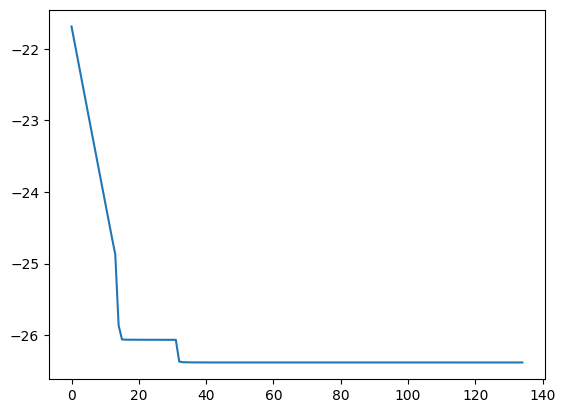

In [5]:
L = 21
h_x = 1
# h = MPO_Ioannis(h=.5,k=.5,J=1)
h = MPO_TFI(J=1,h_x=h_x)
# h = MPO_XY()
# h = MPO_AL(.1,.2,.3,.4,.5)
mps = MPS(L,d=h.d)
cont = CONT(mps,h)
# print(f'max mem MPS: {mps.ram.max}\n'+f'max mem CONT: {cont.ram.max}') 
sys = dmrg(cont,chi=2,k=50)
obs = observables(mps)
mps.random()
cont.random()
# print('a')
# sys.infinite()


# create folder out if not present
path_out = f'OUT_{h_x}/'
if os.path.isdir(path_out):
    shutil.rmtree(path_out)
os.mkdir(path_out)


sys.chi = 100
EE = []
EE_pre = []
k = 0 


for site,dir in tqdm(mps.first_sweep()):
    # print(site)
    En,_,_ = sys.step2sites(site,dir=dir,stage='Final')
    # EE.append(En)

# print(f'mem available MPS: {(mps.ram.max-mps.ram.current_size) /1024**3:.4f} GB')
# print(f'mem available CONT: {(cont.ram.max-cont.ram.current_size)/1024**3:.4f} GB')

for site,dir in tqdm(mps.sweep()):
    En,_,_ = sys.step2sites(site,dir=dir,exc='off')
    EE.append(En)

# print(f'mem available MPS: {(mps.ram.max-mps.ram.current_size)/1024**3:.4f} GB')
# print(f'mem available CONT: {(cont.ram.max-cont.ram.current_size)/1024**3:.4f} GB')

k = 0
while True:
    for site,dir in tqdm(mps.sweep()):
        En,_,_ = sys.step2sites(site,dir=dir,exc='off')
        EE.append(En)

    # print(f'mem available MPS: {(mps.ram.max-mps.ram.current_size)/1024**3:.4f} GB')
    # print(f'mem available CONT: {(cont.ram.max-cont.ram.current_size)/1024**3:.4f} GB')

    k += 1
    sys.chi += 200
    sys.k += 50
    if k == 3:
        break

# Final sweep to store observables
for site,dir in mps.right_sweep():
    _,S,_ = sys.step2sites(site,dir=dir,stage='Final')

    # Store local magnetization
    if site == 2:
        o1,o2 = obs.bound_left(site-1,h.X)
        with open(path_out + 'X.txt','a') as fz:
            fz.write(f'{site} {o1.real} \n')
            fz.write(f'{site} {o2.real} \n')

    with open(path_out + 'X.txt','a') as fz:
            fz.write(f'{site} {obs.single_site(site,h.X).real} \n')

    if site == L-3:
        o1,o2 = obs.bound_right(site+1,h.X)
        with open(path_out + 'X.txt','a') as fz:
            fz.write(f'{site} {o1.real} \n')
            fz.write(f'{site} {o2.real} \n')

    # Store entanglement entropy
    with open(path_out + 'S.txt','a') as fs:
        if site == 2:
            s0,s1 = obs.left_EE()
            fs.write(f'{0} {1} {s0}\n')
            fs.write(f'{1} {2} {s1}\n')

        fs.write(f'{site} {site+1} {S} \n')

        if site == L-3:
            fs.write(f'{site+1} {site+2} {obs.right_EE()}\n')


    # Store all two point correlations from site

    # obs.all_corr(path_out + 'ZZstring.txt',site,string=h.Z,obs1=h.Z)
    obs.all_corr(path_out + 'ZZcorr.txt',site,string=h.Id,obs1=h.Z)

    # if site == 10:
    #     ZZ_10_13 = obs.two_sites(site,site+3,string=h.Id,obs1=h.Id)

plt.plot(EE[1:])

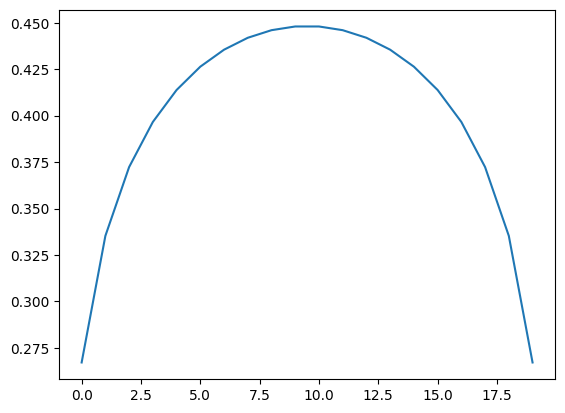

In [3]:
S = np.loadtxt('OUT_1/S.txt')
plt.plot(S[:,2])

In [ ]:
X_05 = np.loadtxt('OUT_0.5/X.txt')
X_2 = np.loadtxt('OUT_2/X.txt')

In [ ]:
ZZ = np.loadtxt('OUT_1/ZZcorr.txt',dtype='complex')
ZZ_2 = []
for zz in ZZ:
    if zz[1]-zz[0] == 1:
        ZZ_2.append(zz[2].real)
    
ZZ = np.loadtxt('OUT_0.5/ZZcorr.txt',dtype='complex')
ZZ_05 = []
for zz in ZZ:
    if zz[1]-zz[0] == 1:
        ZZ_05.append(zz[2].real)


In [ ]:
fig,ax = plt.subplots(1,2,figsize=(14,6))

ax[0].plot(X_05[2:-2,1],'o--')
ax[0].plot(ZZ_2,'x--')
ax[0].plot(X_2[2:-2,1],'o--')
ax[0].plot(ZZ_05,'x--')
# ax[1].plot(np.array(ZZ_05)-X_2[2:-2,1],'o--')
# ax[1].plot(np.array(ZZ_2)-X_05[2:-2,1],'x--')

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(EE[1:], marker='o', label='Energy')
plt.plot(EE_pre[2:],marker='x',label='Pre')
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.title('DMRG Energy Convergence')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()